In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pickle
import random
import gc
import json
from copy import deepcopy
import math
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import astropy.units as u
from astropy.coordinates import SkyCoord
from sklearn.metrics import accuracy_score, f1_score

sys.path.append('..')
from env_config import DATA_PATH, PROJECT_PATH, STORAGE_PATH
from utils import read_fits_to_pandas
from ztf import ZTF_DATES
from ml import LIMITING_MAGS
from features import FEATURES_DICT, add_colors, get_features
from sdss import read_sdss
from catalog import find_duplicates

/home/sjnakoneczny/tools/anaconda3/envs/py39-ztf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/sjnakoneczny/workspace/ztf-agn/notebooks/../ztf.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 100
sns.set_style('ticks', {'axes.grid': False})
pd.set_option('mode.chained_assignment', None)
%matplotlib inline

/home/sjnakoneczny/workspace/ztf-agn/notebooks/ipykernel_3636875/781861970.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [4]:
ztf_date = ZTF_DATES['DR 20']
filter = 'g'

# Produce the files

In [ ]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['id', 'ra', 'dec', 'n_obs', 'mag_median', 'CLASS']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [ ]:
# Read ZTF duplicates
path_dups = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_dups = os.path.join(STORAGE_PATH, path_dups)

cols = ['is_duplicate']
preds_dups = pd.read_csv(path_dups, usecols=cols)

In [ ]:
# Read XGB predictions
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [ ]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

## All QSO file

In [8]:
# Get only QSOs
idx = preds_xgb['y_pred'] == 1

In [9]:
# Merge DFs
preds_ztf = preds_ztf.loc[idx].reset_index(drop=True)
preds_xgb = preds_xgb.loc[idx].reset_index(drop=True)
preds_wise = preds_wise.loc[idx].reset_index(drop=True)
data = pd.concat([preds_ztf, preds_xgb, preds_wise], axis=1)
gc.collect()

0

In [10]:
# Remove z_pred where no WISE features
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_indices = data.index[data.isna()[wise_cols].any(axis=1)]

data.loc[nan_indices, 'z_pred'] = np.nan

In [12]:
# Rename columns
to_save = data[['id', 'ra', 'dec', 'n_obs', 'mag_median', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']]
to_save = to_save.rename(columns={
    'id': 'ID',
    'y_galaxy': 'p_galaxy',
    'y_qso': 'p_QSO',
    'y_star': 'p_star',
    'z_pred': 'redshift',
})

In [13]:
# Save
to_save.to_csv(os.path.join(STORAGE_PATH, 'ZTF/ZTF_20240117/ZTF_all_QSO.csv'), index=False)

In [14]:
to_save

,ID,ra,dec,n_obs,mag_median,p_galaxy,p_QSO,p_star,redshift
0,10202361000000,24.985956,-29.608840,25,20.167160,0.228304,0.769908,0.001788,1.089791
1,10202361000185,25.661731,-29.663325,25,20.119190,0.221202,0.772406,0.006391,3.132066
2,10202361000253,25.379980,-29.688877,39,20.015670,0.241620,0.641579,0.116800,2.491261
3,10202361000343,25.782600,-29.726787,28,20.409875,0.258913,0.520634,0.220453,2.671818
4,10202361000485,24.991175,-29.798067,35,20.174720,0.133598,0.459838,0.406565,NaN
...,...,...,...,...,...,...,...,...,...
56842406,11896431004662,83.789953,87.633756,36,19.940110,0.024920,0.973525,0.001556,0.671892
56842407,11896431005012,87.070715,87.594205,40,19.676725,0.009629,0.990118,0.000253,1.284373
56842408,11896431005468,76.518578,87.452421,35,19.647065,0.017200,0.940169,0.042631,NaN
56842409,11896431007656,73.459380,87.897313,29,19.919975,0.302616,0.695111,0.002272,0.756517


## QZO file

In [ ]:
# Get only QSOs
idx = preds_xgb['y_pred'] == 1

In [ ]:
# Merge DFs
preds_ztf = preds_ztf.loc[idx].reset_index(drop=True)
preds_dups = preds_dups.loc[idx].reset_index(drop=True)
preds_xgb = preds_xgb.loc[idx].reset_index(drop=True)
preds_wise = preds_wise.loc[idx].reset_index(drop=True)
data = pd.concat([preds_ztf, preds_dups, preds_xgb, preds_wise], axis=1)
gc.collect()

In [15]:
# Size of all ZTF + WISE QSOs
tmp = data.loc[(data['y_pred'] == 1) & (data['is_duplicate'] == False)]
tmp.shape

(53476952, 17)

In [11]:
# Mangitude and n_obs cut
data['is_custom'] = data['mag_median'] < (data['n_obs'] / 80 + 20.375)

In [13]:
# Extract the final catalog
qzo = data.loc[data['y_qso'] > 0.9]
qzo = qzo.loc[qzo['is_custom'] == True]
qzo = qzo.loc[qzo['is_duplicate'] == False]
qzo = qzo.reset_index(drop=True)

qzo.shape

(5323428, 17)

In [16]:
# Number of WISE matches in all bands
qzo.dropna(subset=['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']).shape

(1754371, 17)

In [53]:
1754371 / 5323428

0.3295566315539536

In [35]:
# Remove z_pred where no WISE features
wise_cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
nan_indices = qzo.index[qzo.isna()[wise_cols].any(axis=1)]

qzo.loc[nan_indices, 'z_pred'] = np.nan

In [48]:
# Rename columns
to_save = qzo[['id', 'ra', 'dec', 'n_obs', 'mag_median', 'y_galaxy', 'y_qso', 'y_star', 'z_pred']]
to_save = to_save.rename(columns={
    'id': 'ID',
    'y_galaxy': 'p_galaxy',
    'y_qso': 'p_QSO',
    'y_star': 'p_star',
    'z_pred': 'redshift',
})

In [49]:
# Save
to_save.to_csv(os.path.join(STORAGE_PATH, 'ZTF/ZTF_20240117/QZO.csv'), index=False)

In [50]:
to_save

,ID,ra,dec,n_obs,mag_median,p_galaxy,p_QSO,p_star,redshift
0,10202361000706,25.764548,-29.881832,82,18.599430,0.001310,0.997978,0.000712,2.067709
1,10202361000727,25.644028,-29.891646,47,19.717270,0.010979,0.988165,0.000856,2.026701
2,10202361000740,25.542810,-29.898190,34,20.061275,0.000138,0.999782,0.000080,2.252488
3,10202361000807,25.032535,-29.931152,44,19.915520,0.004803,0.993133,0.002064,1.022533
4,10202361000808,25.268425,-29.929151,22,20.474525,0.001696,0.998043,0.000261,2.068923
...,...,...,...,...,...,...,...,...,...
5323423,11896431000414,76.769793,88.218469,44,19.592375,0.009029,0.975875,0.015096,2.911648
5323424,11896431003519,71.430276,87.684710,38,19.782422,0.002634,0.997049,0.000317,1.385970
5323425,11896431004662,83.789953,87.633756,36,19.940110,0.024920,0.973525,0.001556,0.671892
5323426,11896431005012,87.070715,87.594205,40,19.676725,0.009629,0.990118,0.000253,1.284373


# Validation

## Duplicates

In [11]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

# Remove ra, dec
cols = ['n_obs', 'QSO']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [16]:
preds_ztf.shape

(788700127, 3)

In [15]:
# Read all files
stripe_width = 1
idx_dup = []
for x in tqdm(range(0, 360, stripe_width)):
    path_subset = 'ZTF/ZTF_{}/catalog_v2_dups/ZTF_{}_{}-band__v2__dups_ra-{}.csv'.format(ztf_date, ztf_date, filter, x)
    path_subset = os.path.join(STORAGE_PATH, path_subset)
    subset = pd.read_csv(path_subset, index_col='Unnamed: 0')
    
    dups = subset.loc[subset['is_duplicate'] == True]
    idx_dup.extend(dups.index)

  0%|          | 0/360 [00:00<?, ?it/s]

In [17]:
len(idx_dup)

255862987

In [25]:
preds_ztf['is_duplicate'] = False
preds_ztf.loc[idx_dup, 'is_duplicate'] = True

In [26]:
preds_ztf['is_duplicate'].sum()

255352419

In [66]:
# Test the area around RA=0/360
data_tmp = data[['ra', 'dec', 'n_obs']]

delta = 0.0003  # 1 arcsec = 000277778
subset = data_tmp.loc[(data_tmp['ra'] < delta) | (data_tmp['ra'] > 360 - delta)]

In [67]:
subset.shape

(160, 3)

In [68]:
# Find duplicates within a subset
subset = find_duplicates(subset, with_tqdm=False)

In [70]:
n_dups = subset['is_duplicate'].sum()
print('n={}\tn_dups={}\t({:.1f}%)'.format(len(subset), n_dups, n_dups/len(subset) * 100))

n=160	n_dups=41	(25.6%)


In [71]:
idx_dup = subset.loc[subset['is_duplicate'] == True].index

In [72]:
data['is_duplicate'].sum()

255352419

In [73]:
data.loc[idx_dup, 'is_duplicate'] = True

In [74]:
data['is_duplicate'].sum()

255352419

In [27]:
# Save
path_output = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_output = os.path.join(STORAGE_PATH, path_output)
preds_ztf['is_duplicate'].to_csv(path_output, index=False)

## Get cross-match

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

cols = ['ra', 'dec', 'n_obs', 'mag median', 'CLASS']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [6]:
# Read SDSS
columns = ['PLUG_RA', 'PLUG_DEC', 'CLASS', 'Z', 'ZWARNING']
data_sdss = read_sdss(dr=18, clean=True, columns=columns)

Original SDSS: 5261255
Cleaning SDSS: 4398710


In [7]:
# Build positions
positions_ztf = SkyCoord(
    ra=preds_ztf['ra'].to_numpy() * u.degree,
    dec=preds_ztf['dec'].to_numpy() * u.degree,
)
positions_sdss = SkyCoord(
    ra=data_sdss['PLUG_RA'].to_numpy() * u.degree,
    dec=data_sdss['PLUG_DEC'].to_numpy() * u.degree,
)

In [8]:
# Run cross-match
idx_sdss, idx_ztf, sep_2d, dist_3d = positions_ztf.search_around_sky(positions_sdss, 1 * u.arcsec)

In [9]:
# Get indices of the longests matches
cross_idx = pd.DataFrame({'idx_sdss': idx_sdss, 'idx_ztf': idx_ztf})
cross_idx['n_obs'] = preds_ztf.loc[idx_ztf]['n_obs'].reset_index(drop=True)
longests_idx = cross_idx.loc[cross_idx.groupby(['idx_sdss'])['n_obs'].idxmax()]

In [10]:
# Get the final cross-match indices
idx_ztf = longests_idx['idx_ztf'].to_list()
idx_sdss = longests_idx['idx_sdss'].to_list()

In [11]:
# Read XGB predictions
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'z_pred']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [12]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [13]:
# Build cross-matched DF
tmp_ztf = preds_ztf.loc[idx_ztf].reset_index(drop=True)
tmp_xgb = preds_xgb.loc[idx_ztf].reset_index(drop=True)
tmp_wise = preds_wise.loc[idx_ztf].reset_index(drop=True)
tmp_sdss = data_sdss.loc[idx_sdss].reset_index(drop=True)

preds = pd.concat([tmp_ztf, tmp_xgb, tmp_wise], axis=1)

preds = preds.join(tmp_sdss, lsuffix='_ZTF', rsuffix='_SDSS')

# Change labels back to strings
cls_dict = {0: 'GALAXY', 1: 'QSO', 2: 'STAR'}
preds['CLASS_ZTF'] = preds['CLASS_ZTF'].apply(lambda x: cls_dict[x])
preds['y_pred'] = preds['y_pred'].apply(lambda x: cls_dict[x])

In [14]:
# Non WISE subset
preds_wise = preds.dropna(subset=FEATURES_DICT['WISE'])
preds_non_wise = preds.loc[~preds.index.isin(preds_wise.index)].reset_index(drop=True)
preds_wise = preds_wise.reset_index(drop=True)

## Classification

In [15]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds['CLASS_SDSS'], preds['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds['CLASS_SDSS'], preds['CLASS_ZTF'], average=None), 2))

Acc: 0.88
F1:  [0.89 0.88 0.87]


In [16]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds['CLASS_SDSS'], preds['y_pred'])))
print('F1: ', np.round(f1_score(preds['CLASS_SDSS'], preds['y_pred'], average=None), 2))

Acc: 0.94
F1:  [0.95 0.94 0.92]


In [17]:
# Subsets
preds_cut = preds.loc[preds['mag median'] < preds['n_obs'] / 80 + 20.375]

In [18]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'], average=None), 2))

Acc: 0.91
F1:  [0.91 0.93 0.89]


In [19]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'], average=None), 2))

Acc: 0.96
F1:  [0.96 0.96 0.94]


In [20]:
# Subsets
preds_cut = preds.loc[(preds['mag median'] < 20.8) & (preds['n_obs'] > 100)]

In [21]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['CLASS_ZTF'], average=None), 2))

Acc: 0.96
F1:  [0.96 0.96 0.94]


In [22]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'])))
print('F1: ', np.round(f1_score(preds_cut['CLASS_SDSS'], preds_cut['y_pred'], average=None), 2))

Acc: 0.98
F1:  [0.98 0.98 0.97]


In [23]:
# WISE subset

In [24]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_wise['CLASS_SDSS'], preds_wise['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_wise['CLASS_SDSS'], preds_wise['CLASS_ZTF'], average=None), 2))

Acc: 0.92
F1:  [0.93 0.9  0.9 ]


In [25]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_wise['CLASS_SDSS'], preds_wise['y_pred'])))
print('F1: ', np.round(f1_score(preds_wise['CLASS_SDSS'], preds_wise['y_pred'], average=None), 2))

Acc: 0.97
F1:  [0.98 0.98 0.96]


In [26]:
# Non WISE subset

In [27]:
# ZTF classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['CLASS_ZTF'])))
print('F1: ', np.round(f1_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['CLASS_ZTF'], average=None), 2))

Acc: 0.77
F1:  [0.67 0.81 0.81]


In [28]:
# ZTF + WISE classification score
print('Acc: {:.2f}'.format(accuracy_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['y_pred'])))
print('F1: ', np.round(f1_score(preds_non_wise['CLASS_SDSS'], preds_non_wise['y_pred'], average=None), 2))

Acc: 0.83
F1:  [0.73 0.84 0.87]


## Redshift

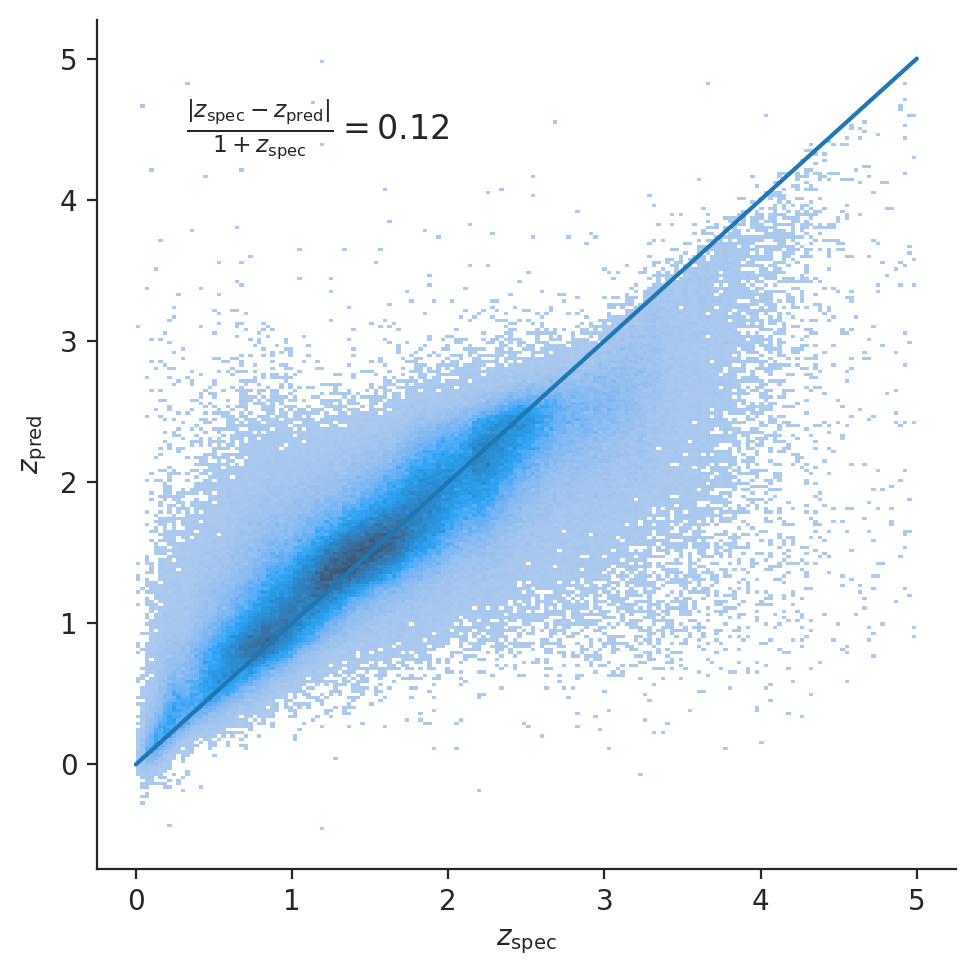

In [29]:
# Redshift validation
preds_qso = preds.loc[preds['CLASS_SDSS'] == 'QSO']
preds_qso_wise = preds_qso.dropna(subset=FEATURES_DICT['WISE']).reset_index(drop=True)

z_max = 5
preds_qso_wise = preds_qso_wise.loc[(preds_qso_wise['Z'] < z_max) & (preds_qso_wise['z_pred'] < z_max)]

z_true = preds_qso_wise['Z']
z_pred = preds_qso_wise['z_pred']
z_err = np.mean(abs(z_true - z_pred) / (1 + z_true))

ax = sns.displot(x=z_true, y=z_pred)
plt.plot(range(z_max + 1), range(z_max + 1), '-')

text = '$\\frac{|z_{\mathrm{spec}} - z_{\mathrm{pred}}|}{1 + z_{\mathrm{spec}}} = ' + str(np.round(z_err, 2)) + '$'
ax.fig.text(0.2, 0.85, text, fontsize='large')

ax.set_xlabels('$z_{\mathrm{spec}}$')
ax.set_ylabels('$z_{\mathrm{pred}}$')

plt.tight_layout()
plt.show()

# WISE coverage

In [10]:
# Read WISE features
path_wise = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_WISE.csv'.format(ztf_date, ztf_date, filter)
path_wise = os.path.join(STORAGE_PATH, path_wise)

cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
preds_wise = pd.read_csv(path_wise, usecols=cols)

In [11]:
# Read XGB preds
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_qso']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [12]:
# Merge both
data = preds_wise.join(preds_xgb)

In [13]:
cols = ['AllWISE__w1mpro', 'AllWISE__w2mpro', 'AllWISE__w3mpro', 'AllWISE__w4mpro']
data_wise = data.dropna(subset=cols)

In [8]:
# Full ZTF coverage with WISE
a = data.shape[0]
b = data_wise.shape[0]
print(a, b, b/a)

788700127 322857294 0.4093536731483245


In [ ]:
# QSOs coverage with WISE

In [14]:
data_wise.loc[data_wise['y_qso'] > 0.9].shape

(3117668, 5)

In [15]:
data.loc[data['y_qso'] > 0.9].shape

(8268472, 5)

In [16]:
3117668 / 8268472

0.3770549141364934

# Counts

In [5]:
# Read ZTF preds
path_ztf = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2.csv'.format(ztf_date, ztf_date, filter)
path_ztf = os.path.join(STORAGE_PATH, path_ztf)

# Remove ra, dec
cols = ['ra', 'dec', 'n_obs', 'mag_median', 'CLASS', 'QSO']
preds_ztf = pd.read_csv(path_ztf, usecols=cols)

In [8]:
# Size of the full inference set
preds_ztf.shape

(788700127, 6)

In [7]:
# Read ZTF duplicates
path_dups = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_dups.csv'.format(ztf_date, ztf_date, filter)
path_dups = os.path.join(STORAGE_PATH, path_dups)

cols = ['is_duplicate']
preds_dups = pd.read_csv(path_dups, usecols=cols)

In [9]:
preds_dups['is_duplicate'].sum()

255352419

In [10]:
# Read WISE preds
path_xgb = 'ZTF/ZTF_{}/catalog_ZTF_{}_{}-band__v2_XGB.csv'.format(ztf_date, ztf_date, filter)
path_xgb = os.path.join(STORAGE_PATH, path_xgb)

cols = ['y_pred', 'y_qso']
preds_xgb = pd.read_csv(path_xgb, usecols=cols)

In [12]:
# Merge all
# data = preds_ztf.join(preds_dups).join(preds_xgb)
data = preds_ztf.join(preds_dups).join(preds_xgb)
# data = pd.concat([preds_ztf, preds_dups, preds_xgb], axis=1)

In [21]:
# Collect single DFs
preds_ztf = 0
preds_dups = 0
preds_xgb = 0
gc.collect()

0

In [15]:
# Get QSOs
qso = data.loc[(data['CLASS'] == 1) | (data['y_pred'] == 1)]
qso = qso.reset_index(drop=True)

In [16]:
# Add cuts
qso['is_n_obs'] = qso['n_obs'] > 100
qso['is_mag'] = qso['mag_median'] < LIMITING_MAGS['g']
qso['is_custom'] = qso['mag_median'] < (qso['n_obs'] / 80 + 20.375)

In [17]:
qso_dedup = qso.loc[qso['is_duplicate'] == False]

In [18]:
qso.shape

(78078450, 12)

In [19]:
qso_dedup.shape

(57968590, 12)

In [20]:
qso['is_duplicate'].sum()

20109860

In [22]:
# Get QSO subsets
qso_ztf = qso_dedup.loc[qso_dedup['CLASS'] == 1]
qso_wise = qso_dedup.loc[qso_dedup['y_pred'] == 1]

In [23]:
qso_ztf.shape

(35538007, 12)

In [24]:
qso_wise.shape

(45927239, 12)

In [25]:
# Initialize statistics
p_min_arr = np.array([x / 100 for x in range(0, 100, 1)])
n_qso = defaultdict(list)

In [26]:
# Calculate ZTF counts
for p_min in tqdm(p_min_arr):
    tmp = qso_ztf.loc[qso_ztf['QSO'] > p_min]
    n_qso['ZTF all'].append(tmp.shape[0])
    n_qso['ZTF or'].append(tmp.loc[tmp['is_mag'] | tmp['is_n_obs']].shape[0])
    n_qso['ZTF mag'].append(tmp.loc[tmp['is_mag']].shape[0])
    n_qso['ZTF obs'].append(tmp.loc[tmp['is_n_obs']].shape[0])
    n_qso['ZTF and'].append(tmp.loc[tmp['is_mag'] & tmp['is_n_obs']].shape[0])
    n_qso['ZTF custom'].append(tmp.loc[tmp['is_custom']].shape[0])
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# Calculate WISE counts
for p_min in tqdm(p_min_arr):
    tmp = qso_wise.loc[qso_wise['y_qso'] > p_min]
    n_qso['WISE all'].append(tmp.shape[0])
    n_qso['WISE or'].append(tmp.loc[tmp['is_mag'] | tmp['is_n_obs']].shape[0])
    n_qso['WISE mag'].append(tmp.loc[tmp['is_mag']].shape[0])
    n_qso['WISE obs'].append(tmp.loc[tmp['is_n_obs']].shape[0])
    n_qso['WISE and'].append(tmp.loc[tmp['is_mag'] & tmp['is_n_obs']].shape[0])
    n_qso['WISE custom'].append(tmp.loc[tmp['is_custom']].shape[0])
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

ZTF all 6124844
ZTF custom 5331887
ZTF or 4956997
ZTF obs 4071301
ZTF mag 3291338
ZTF and 2405642


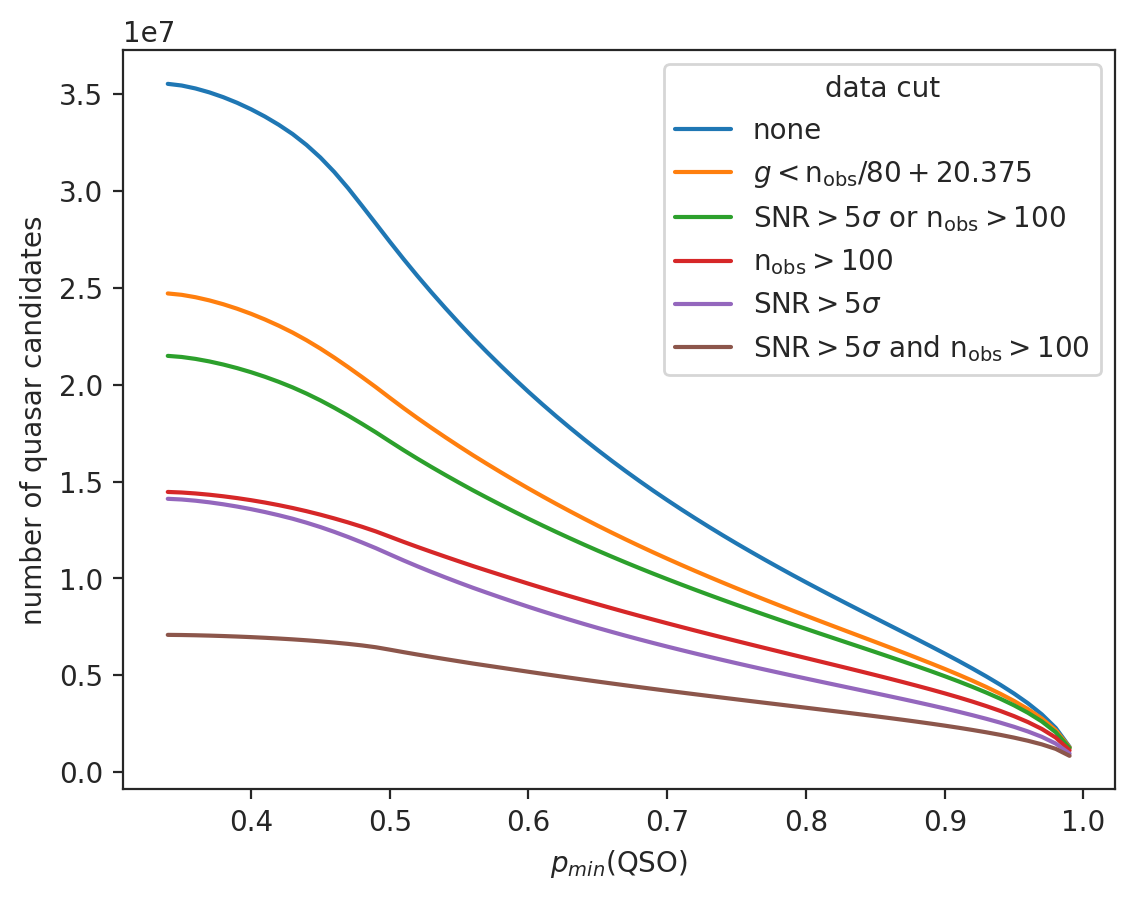

In [34]:
# Plot the ZTF counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'ZTF all': 'none',
    'ZTF custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'ZTF or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'ZTF obs': '$\mathrm{n_{obs}} > 100$',
    'ZTF mag': '$\mathrm{SNR} > 5\sigma$',
    'ZTF and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key])

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

WISE all 6644605
WISE custom 4849574
WISE or 4284010
WISE obs 3529222
WISE mag 2468580
WISE and 1713792


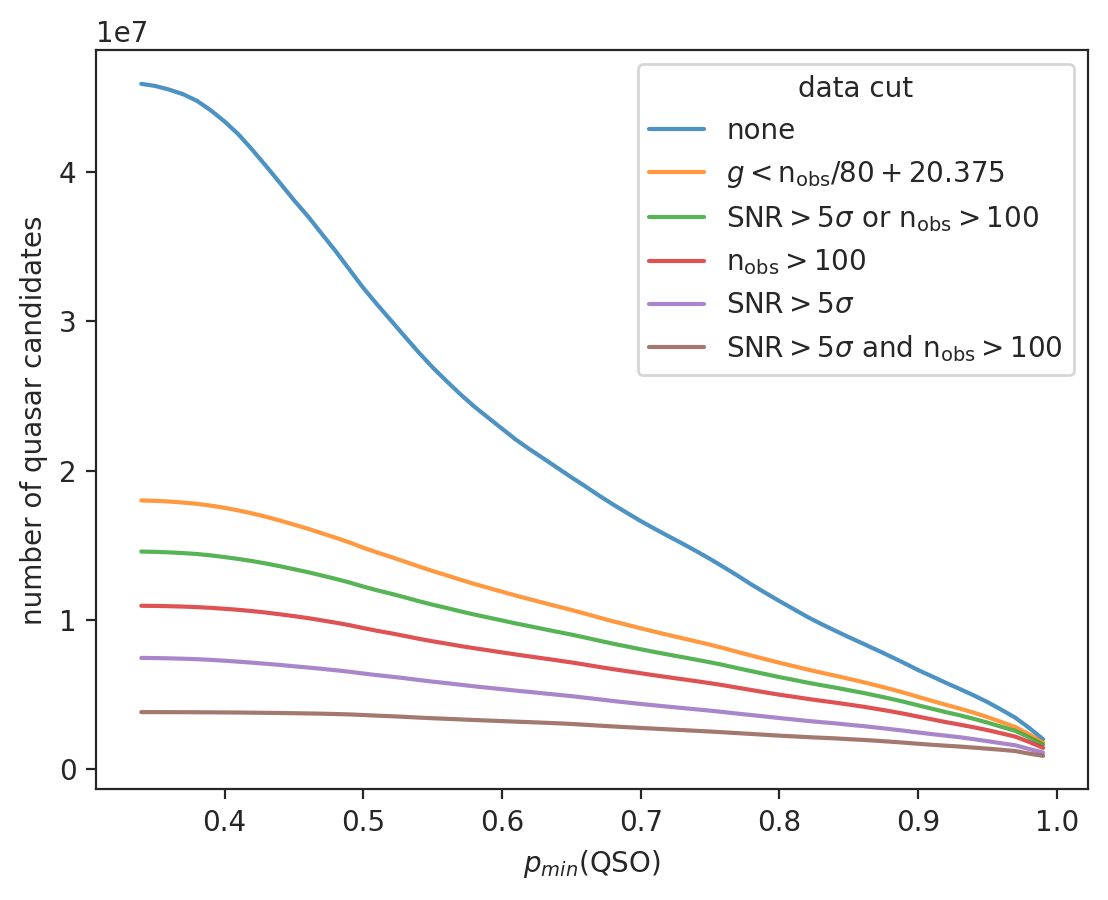

In [35]:
# Plot the WISE counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    'WISE all': 'none',
    'WISE custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'WISE or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'WISE obs': '$\mathrm{n_{obs}} > 100$',
    'WISE mag': '$\mathrm{SNR} > 5\sigma$',
    'WISE and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

WISE custom 4849574
WISE or 4284010
WISE obs 3529222
WISE mag 2468580
WISE and 1713792


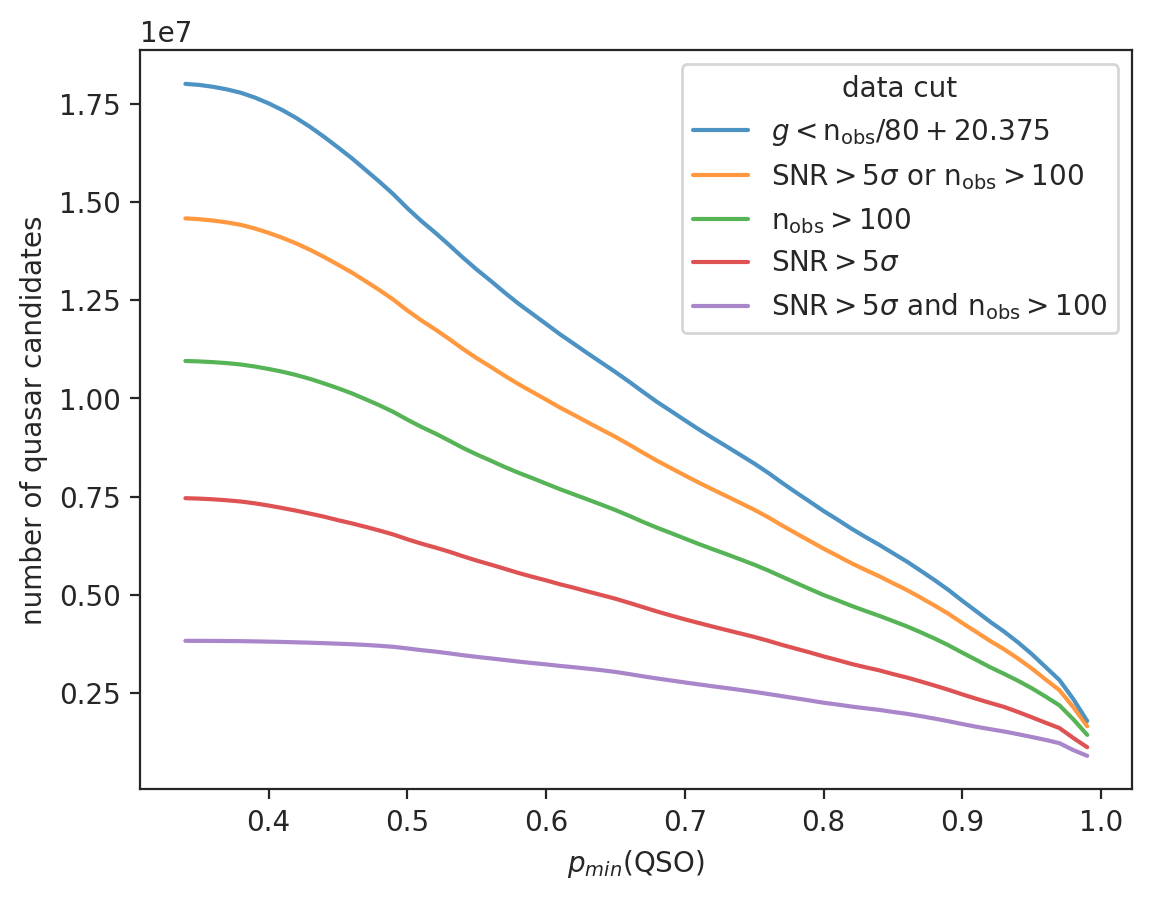

In [36]:
# Plot the WISE counts
idx = np.where(p_min_arr > 1/3)[0][0]

labels = {
    # 'WISE all': 'none',
    'WISE custom': '$g < \mathrm{n_{obs}} / 80 + 20.375$',
    'WISE or': '$\mathrm{SNR} > 5\sigma \mathrm{\ or\ } \mathrm{n_{obs}} > 100$',
    'WISE obs': '$\mathrm{n_{obs}} > 100$',
    'WISE mag': '$\mathrm{SNR} > 5\sigma$',
    'WISE and': '$\mathrm{SNR} > 5\sigma \mathrm{\ and\ } \mathrm{n_{obs}} > 100$',
}
for key in labels:
    print(key, n_qso[key][90])
    plt.plot(p_min_arr[idx:], n_qso[key][idx:], label=labels[key], alpha=0.8)

plt.legend(title='data cut')
plt.xlabel('$p_{min}(\mathrm{QSO})$')
plt.ylabel('number of quasar candidates')
plt.show()

In [31]:
# Make a table
idx = np.where([x in [0.3, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999] for x in p_min_arr])[0]
df = []
labels = ['WISE all', 'WISE custom', 'WISE or', 'WISE obs', 'WISE mag', 'WISE and']
for key in labels:
    row = {
        'data cut': key
    }
    for i in idx:
        row[p_min_arr[i]] = n_qso[key][i] / 1e6
    df.append(row)
df = pd.DataFrame(df)
print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))

\begin{tabular}{lrrrrrr}
\toprule
   data cut &   0.3 &   0.5 &   0.8 &  0.9 &  0.95 &  0.99 \\
\midrule
   WISE all & 45.93 & 32.23 & 11.26 & 6.64 &  4.50 &  2.02 \\
WISE custom & 18.01 & 14.84 &  7.14 & 4.85 &  3.50 &  1.79 \\
    WISE or & 14.59 & 12.24 &  6.18 & 4.28 &  3.13 &  1.66 \\
   WISE obs & 10.96 &  9.46 &  5.00 & 3.53 &  2.63 &  1.44 \\
   WISE mag &  7.46 &  6.42 &  3.43 & 2.47 &  1.89 &  1.12 \\
   WISE and &  3.83 &  3.64 &  2.26 & 1.71 &  1.38 &  0.90 \\
\bottomrule
\end{tabular}



/home/sjnakoneczny/workspace/ztf-agn/notebooks/ipykernel_3625073/995337302.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, na_rep='', float_format='%.2f', index=False))


In [32]:
# WISE QSO percentage
45927239 

0.08611125221147477

In [33]:
# QZO percentage
4849574 / (788700127 - 255352419)

0.009092706178836715